In [1]:
# DisulfideBond Playground
# Playing with the DisulfideBond class
# Author: Eric G. Suchanek, PhD.
# (c) 2023 Eric G. Suchanek, PhD., All Rights Reserved
# License: MIT
# Last Modification: 2/18/23
# Cα N, Cα, Cβ, C', Sγ Å °

import pandas as pd
import numpy

import pyvista as pv
from pyvista import set_plot_theme
import plotly.express as px

from Bio.PDB import *

# for using from the repo we 
import proteusPy
from proteusPy import *
from proteusPy.data import *

from proteusPy.Disulfide import *
from proteusPy.DisulfideList import DisulfideList, load_disulfides_from_id
from proteusPy.DisulfideLoader import Load_PDB_SS, DisulfideLoader, DisulfideClass_Constructor
from proteusPy.data import DATA_DIR

# pyvista setup for notebooks
pv.set_jupyter_backend('trame')
set_plot_theme('dark')

from plotly.subplots import make_subplots


In [2]:
PDB_SS = Load_PDB_SS(verbose=True, subset=False)
PDB_SS.describe()


-> load_PDB_SS(): Reading /Users/egs/repos/proteusPy/proteusPy/data/PDB_SS_ALL_LOADER.pkl... done.
    =========== RCSB Disulfide Database Summary ==============
       =========== Built: 2023-02-26 22:26:52 ==============
PDB IDs present:                    35818
Disulfides loaded:                  120494
Average structure resolution:       2.34 Å
Lowest Energy Disulfide:            2q7q_75D_140D
Highest Energy Disulfide:           1toz_456A_467A
Ca distance cutoff:                 8.00 Å
Total RAM Used:                     31.05 GB.
    ================= proteusPy: 0.61dev =======================


In [4]:
from proteusPy.DisulfideLoader import create_trinary_classes

tors = PDB_SS.getTorsions()
trin = create_trinary_classes(tors)
trin.head(32)

,class_id,ss_id,count,incidence,percentage
0,*****,"[7ngb_324A_339A, 3wu7_6A_127A, 3wua_6A_127A, 3...",1243,0.010316,1.031587
1,****@,"[4ove_404A_416A, 1c7t_56A_66A, 3wky_682A_687A,...",7,0.000058,0.005809
2,****^,"[4g03_168A_177A, 4luh_557A_566A, 3lu7_168A_177...",25,0.000207,0.020748
3,****_,"[7nd8_743A_749A, 2mz0_26A_49A, 4btt_8A_21A, 4b...",197,0.001635,0.163494
4,***@@,[5y2l_52A_277A],1,0.000008,0.000830
5,***^*,"[7pmv_1157A_1196A, 1b0i_328A_335A, 4fi3_183F_2...",9,0.000075,0.007469
6,***^@,"[6bjr_86A_126A, 3m7p_360A_386A, 8d6o_534A_821A...",4,0.000033,0.003320
7,***^^,[4a5b_341A_352A],1,0.000008,0.000830
8,***^_,"[8d6g_314A_325A, 1pk2_28A_70A, 1vfd_170A_181A,...",21,0.000174,0.017428
9,***_*,"[2mw7_21A_34A, 7ezc_71A_159A, 7lfs_133A_163A, ...",441,0.003660,0.365993


<AxesSubplot: xlabel='class_id'>

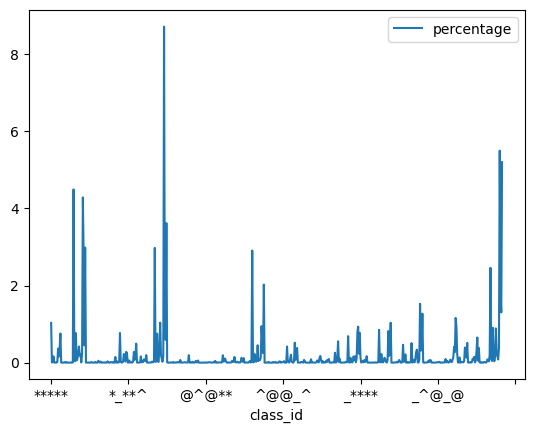

In [6]:
trin.plot(x='class_id', y='percentage')

<AxesSubplot: xlabel='class_id'>

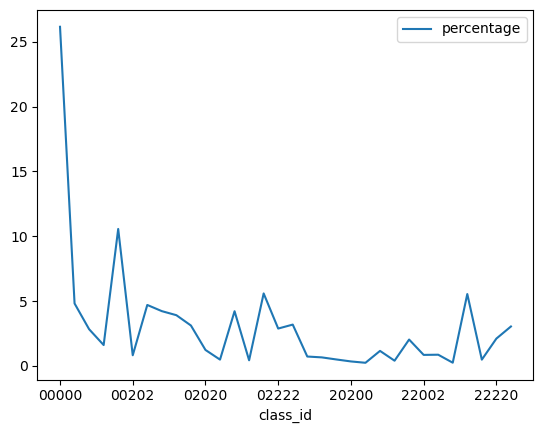

In [9]:
from proteusPy.DisulfideLoader import create_classes
binary = create_classes(tors)
binary.plot(x='class_id', y='percentage')


In [11]:
from proteusPy.utility import generate_vector_dataframe

trinary = generate_vector_dataframe(base=3)
trinary.head(64)

,chi1,chi2,chi3,chi4,chi5
0,-,-,-,-,-
1,-,-,-,-,+
2,-,-,-,-,*
3,-,-,-,+,-
4,-,-,-,+,+
...,...,...,...,...,...
59,-,*,-,+,*
60,-,*,-,*,-
61,-,*,-,*,+
62,-,*,-,*,*


In [13]:
quart = generate_vector_dataframe(base=4)
quart.head(128)


,chi1,chi2,chi3,chi4,chi5
0,-,-,-,-,-
1,-,-,-,-,+
2,-,-,-,-,*
3,-,-,-,-,@
4,-,-,-,+,-
...,...,...,...,...,...
123,-,+,@,*,@
124,-,+,@,@,-
125,-,+,@,@,+
126,-,+,@,@,*


In [ ]:
all_tors_df = PDB_SS.TorsionDF
all_tors_df.describe()

In [ ]:
from proteusPy.data import DATA_DIR
class_filename = f'{DATA_DIR}SS_consensus_class32.pkl'
avg_ss = DisulfideList([], 'A')
with open(class_filename, 'rb') as f:
    avg_ss = pickle.load(f)

In [ ]:
# avg_ss.torsion_df.to_markdown(f'{DATA_DIR}average_ss_byclass.md')
avg_ss.torsion_df.head(32)

In [ ]:
avg_ss.display(style='sb', light=True)

In [ ]:
avg_ss.build_torsion_df
tors = avg_ss.torsion_df
tors.describe()


In [ ]:
rhs = PDB_SS.from_class('+RHStaple')
rhs.TorsionGraph(save=True, light=False, fname=f'/tmp/tst.png')


In [ ]:
import matplotlib.pyplot as plt

#tors.plot('rho')
tors['rho'].hist(density=True, bins=100)

# Add labels and title to the plot
plt.xlabel('rho')
plt.ylabel('Probability Density')
plt.title('Probability Density Histogram')

# Show the plot
plt.show()

In [ ]:
rho = tors['rho']

In [ ]:
rhs = PDB_SS.from_class('+RHStaple')
rhs.TorsionGraph(save=True, light=False, fname=f'/tmp/tst.png')


In [ ]:
PDB_SS.classdf.to_csv(f'{DATA_DIR}PDB_SS_CLASSES.csv')

In [ ]:
start = time.time()

# pyvista setup for notebooks
pv.set_jupyter_backend('trame')
set_plot_theme('dark')

PDB_SS = Load_PDB_SS(verbose=True, subset=False)

_PBAR_COLS = 80

def analyze_classes(loader: DisulfideLoader) -> DisulfideList:
    classes = loader.classdict
    tot_classes = len(classes)
    res_list = DisulfideList([], 'SS_Class_Avg_SS')

    pbar = enumerate(classes)
    for idx, cls in pbar:
        print(f'--> analyze_classes(): {cls} {idx+1}/{tot_classes}')
        class_ss_list = loader.from_class(cls)
        fname = f'./classes/ss_class_{idx}.png'
        class_ss_list.TorsionGraph(display=False, save=True, fname=fname)
        fname2 = f'./classes/ss_consensus_{idx}.png'
        avg_conformation = class_ss_list.Average_Conformation
        ssname = f'{cls}_avg'
        exemplar = Disulfide(ssname)
        exemplar.build_model(avg_conformation[0], avg_conformation[1],
                             avg_conformation[2],avg_conformation[3],
                             avg_conformation[4])
        res_list.append(exemplar)
    return res_list

def build_consensus_list(loader: DisulfideLoader) -> DisulfideList:
    classes = loader.classdict
    tot_classes = len(classes)
    res_list = DisulfideList([], 'SS_Classes')

    pbar = enumerate(classes)
    for idx, cls in pbar:
        print(f'--> build_consensus_list(): {cls} {idx+1}/{tot_classes}')
        class_ss_list = loader.from_class(cls)
        fname2 = f'./classes/ss_consensus_{idx}.png'

        # compute and build a consensus 'average' conformation
        avg_conformation = class_ss_list.Average_Conformation
        ssname = f'{cls}_avg'
        exemplar = Disulfide(ssname)
        exemplar.build_model(avg_conformation[0], avg_conformation[1],
                             avg_conformation[2],avg_conformation[3],
                             avg_conformation[4])
        res_list.append(exemplar)

    return

avg_ss_list = DisulfideList([], 'SS_Class_Consensus')
avg_ss_list = analyze_classes(PDB_SS)


end = time.time()
elapsed = end - start


In [ ]:
avg_ss_list.display(style='sb', light=True)

In [ ]:
rhs = PDB_SS.from_class('+RHStaple')
df = rhs.torsion_df
df_subset = df.iloc[:, 4:]
df_stats = df_subset.describe()

#PDB_SS.list_classes()


In [ ]:
df_stats.head()

In [ ]:
_fname = f'{DATA_DIR}classes/ss_class_rhs.png'
rhs = PDB_SS.from_class('+RHStaple')
rhs.TorsionGraph(light=False, save=True, fname=_fname)

In [ ]:
df = rhs.torsion_df
df_subset = df.iloc[:, 4:]
df_stats = df_subset.describe()
print(df_stats)
df_stats.loc['mean']['ca_distance']
mean_vals = df_stats.loc['mean'].values
std_vals = df_stats.loc['std'].values

std_vals[6]



In [ ]:
chis = df[4]

In [ ]:
rhs.TorsionGraph(light=True,fname='rhstaple.png', save=True)

In [ ]:
tors_df = PDB_SS.getTorsions()
tors_df.describe()

In [ ]:
ss1 = Disulfide('bogus')
ss1.build_model(-60,-60,-84,-60,-60)
ss1.pprint()

In [ ]:
PDB_SS['2q7q_75D_140D']

In [ ]:
PDB_SS2 = Load_PDB_SS(subset=True, verbose=True)
#PDB_SS.describe()


In [ ]:
PDB_SS['5fha']

In [ ]:
PDB_SS2['5fha']

In [ ]:
len(PDB_SS.SSList)
PDB_SS.SSList[306]

In [ ]:
best = PDB_SS.get_by_name('2q7q_75D_140D')
worst = PDB_SS.get_by_name('1zjk_629A_660A')
worst
duo = DisulfideList([best, worst], 'bw')
duo.display(style='sb')

In [ ]:
totSS_list = PDB_SS.SSList
neighbors = best.Torsion_neighbors(totSS_list, 10)
PDB_SS = Load_PDB_SS(verbose=False, subset=True)
tot = neighbors.length
tot


In [ ]:
neighbors

In [ ]:
ssbest = PDB_SS['2q7q']
ssbest.pprint()

In [ ]:
sslist2 = PDB_SS['3k0v']
sslist2

In [ ]:
import py3Dmol
import urllib.request

import py3Dmol
import urllib.request

def Odisplay_pdb_structure():
    # download PDB structure 3q7q
    pdb_url = 'https://files.rcsb.org/download/2q7q.pdb'
    pdb_data = urllib.request.urlopen(pdb_url).read().decode('utf-8')

    # create viewer object
    viewer = py3Dmol.view(width=1024, height=1024)

    # add PDB data to viewer
    viewer.addModel(pdb_data, 'pdb')

    
    # select residues 75 and 150 from chain 'D'
    sel_str = ':D and (resi 75 or resi 140)'
    #viewer.setStyle({'resi': [75, 140], 'chain': 'D'}, {'stick': {'color': 'green', 'radius': 0.6}, 'sphere': {'color': 'green', 'radius': 1}}, sel_str)
    viewer.setStyle(sel_str, {'sphere': {'scale': 0.5}, 'color': 'element'})


    # display all other residues as a ribbon colored by chain
    viewer.setStyle({}, {'cartoon': {'color': 'spectrum'}})

    # center and zoom to selection
    viewer.zoomTo({'sel': sel_str})
    
    # show viewer
    return viewer.show()

import urllib.request
import py3Dmol

def oodisplay_pdb_structure():
    # Download PDB structure 2q7q
    pdb_url = "https://files.rcsb.org/download/2q7q.pdb"
    pdb_file = urllib.request.urlopen(pdb_url).read().decode("utf-8")

    # Initialize viewer
    view = py3Dmol.view(width=800, height=600)

    # Select residues 75 and 140 from chain D
    selection = "(resid 81 or resid 113)"

    # Add selected atoms as spheres scaled by atom radius and colored by atom type
    view.addModel(pdb_file, "pdb")
    view.setStyle(selection, {"sphere": {"scale": 0.5}, "color": "element"})

    # Display all other residues as a ribbon colored by secondary structure
    view.setStyle("not " + selection, {"cartoon": {"color": "spectrum"}})

    # Set camera and render the viewer
    view.zoomTo(selection)
    view.render()

import py3Dmol
import requests

def display_pdb_structure():
    # Download PDB structure 2q7q
    pdb_id = '2q7q'
    pdb_url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    pdb_file = requests.get(pdb_url).text
    
    # Initialize viewer
    view = py3Dmol.view(width=800, height=600)
    
    # Select residues 75 and 140 from chain D
    selection = {'chain': 'D', 'resi': '75, 140'}
    
    # Add selected atoms as spheres scaled by atom radius and colored by atom type
    view.addModel(pdb_file, 'pdb')
    view.setStyle(selection, {'sphere': {'scale': 0.5}, 'color': 'element'})
    
    # Display all other residues as a ribbon colored by secondary structure
    view.setStyle({}, {'cartoon': {'color': 'spectrum'}})
    
    # Set camera and render the viewer
    view.zoomTo(selection)
    view.render()

import requests
import py3Dmol

def odisplay_cys_residues():
    # Download PDB structure 2q7q
    pdb_id = '2q7q'
    pdb_url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    pdb_file = requests.get(pdb_url).text
    
    # Initialize viewer
    view = py3Dmol.view(width=800, height=800)
    
    # Select all Cys residues
    selection = {'resn': 'CYS'}
    
    # Add selected atoms as spheres scaled by atom radius and colored green
    view.addModel(pdb_file, 'pdb')
    view.setStyle(selection, {'sphere': {'scale': 0.5}, 'color': 'green'})
    
    # Set camera and render the viewer
    view.zoomTo(selection)
    view.render()


import requests
import py3Dmol

def display_cys_residues():
    # Download PDB structure 2q7q
    pdb_id = '2q7q'
    pdb_url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    pdb_file = requests.get(pdb_url).text

    # Initialize viewer
    view = py3Dmol.view(width=800, height=600)

    # Add protein backbone as ribbon
    view.addModel(pdb_file, 'pdb')
    view.setStyle({'cartoon': {'color': 'spectrum'}})

    # Select all Cys residues and display as green spheres
    selection = {'resn': 'CYS'}
    view.addStyle(selection, {'sphere': {'color': 'green', 'radius': 0.3}})

    # Set camera and render the viewer
    view.zoomTo(selection)
    view.render()

import requests
import py3Dmol

def display_cys_and_ss_bonds():
    # Download PDB structure 2q7q
    pdb_id = '2q7q'
    pdb_url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    pdb_file = requests.get(pdb_url).text

    # Initialize viewer
    view = py3Dmol.view(width=800, height=800)

    # Add protein as sticks
    view.addModel(pdb_file, 'pdb')
    #view.setStyle({'stick': {}})

    # Select all Cys residues and SSBOND bonds and display as green sticks
    cys_selection = {'resn': 'CYS'}
    ssbond_selection = {'ss': 'disulf'}
    view.addStyle(cys_selection, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.2}})
    view.addStyle(ssbond_selection, {'stick': {'colorscheme': 'greenCarbon', 'radius': 1.0}})

    # Set camera and render the viewer
    #view.zoomTo(cys_selection)
    view.render()

import requests
import py3Dmol

def display_disulfide_bonds():
    # Download PDB structure 2q7q
    pdb_id = '2q7q'
    pdb_url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    pdb_file = requests.get(pdb_url).text

    # Initialize viewer
    view = py3Dmol.view(width=800, height=600)

    # Add protein as sticks
    view.addModel(pdb_file, 'pdb')
    view.setStyle({'stick': {}})

    # Select all disulfide bonds and display as green sticks
    ssbond_selection = {'ss': 'disulf'}
    view.addStyle(ssbond_selection, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.2}})

    # Set camera and render the viewer
    view.zoomTo(ssbond_selection)
    view.render()

display_disulfide_bonds()


In [ ]:
import py3Dmol

viewer = py3Dmol.view(query='pdb:2q7q')
viewer.setStyle({'cartoon': {}})

viewer.setStyle({'chain': 'D', 'resn': 'CYS'},{'stick': {'colorscheme': 'lightgreenCarbon'}})
#viewer.addLabel('Chain D', {'fontColor':'orange', 'backgroundColor':'lightgray'}, {'chain': ['D']})
ssbond_selection = {'ss': 'disulf'}
viewer.addStyle(ssbond_selection, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.2}})

#viewer.setStyle({'resn': 'CYS'},{'stick': {'colorscheme': 'orangeCarbon'}})

viewer.show()

In [ ]:
import py3Dmol
viewer.show()

In [ ]:
viewer.setStyle({'resn': 'SSBOND'},{'stick': {'colorscheme': 'greenCarbon'}})
viewer.show()

In [ ]:
from proteusPy.utility import download_file
# Example usage:
url = "https://github.com/suchanek/proteusPy/raw/master/proteusPy/data/PDB_SS_ALL_LOADER.pkl"
directory = "/tmp"

download_file(url, directory)


In [ ]:
from proteusPy.DisulfideList import DisulfideList
SSlist = DisulfideList([],'ss','22')
newss = load_disulfides_from_id('6z9g', verbose=False)
newss.display(light=False)



In [ ]:
import pandas as pd
import numpy

import pyvista as pv
from pyvista import set_plot_theme

from Bio.PDB import *

# for using from the repo we 
import proteusPy
from proteusPy import *
from proteusPy.data import *
from proteusPy.Disulfide import *
from proteusPy.DisulfideList import DisulfideList, load_disulfides_from_id
from proteusPy.DisulfideLoader import Load_PDB_SS


PDB_SS = None

#PDB_SS = DisulfideLoader(verbose=True, subset=False, datadir=DATA_DIR)
PDB_SS = Load_PDB_SS(verbose=True, subset=False)


In [ ]:
def Average_Resolution(ssloader: DisulfideLoader) -> float:
    '''
    Compute and return the average structure resolution for the given list.

    :return: Average resolution (A)
    '''
    res_tot = 0.0
    cnt = 1
    
    IDList = ssloader.IDList

    for ssid in IDList:
        _res = ssloader[ssid].resolution
        if _res is not None and _res != -1.0:
            res_tot += _res
            cnt += 1
    return res_tot / cnt

      

In [ ]:
PDB_SS['4yys']

In [ ]:
ss1 = PDB_SS['4yys_22A_65A']

In [ ]:
ss1.resolution

In [ ]:
Average_Resolution(PDB_SS)

In [ ]:
PDB_SS2 = Load_PDB_SS(verbose=True, subset=True)

In [ ]:
pdb = DisulfideLoader(verbose=True, subset=False)

In [ ]:
ss = pdb['2q7q_75D_140D']
ss

In [ ]:
PDB_SS['4yys']

In [ ]:
sslist = PDB_SS['4yys']
sslist

In [ ]:


sslist = PDB_SS.SSList
LHS_neighbors = sslist.nearest_neighbors(-60, -60, -90, -60, -60, 20.0)
LHS_neighbors.length
# modelss = Disulfide('model', proximal=1, distal=2, pdb_id='EGS')
# modelss.build_model(-60,-60, -90, -60, -60)


In [ ]:

# We use the entire database contained in PDB_SS.SSList for our search here.
# The entire database can be scanned in 13 seconds on the M1 Pro Macbook Pro.

ssmin_enrg, ssmax_enrg = PDB_SS.SSList.minmax_energy()
ssmin_enrg.pprint()
ssmax_enrg.pprint()
minmax = DisulfideList([ssmin_enrg, ssmax_enrg], 'minmax')
#minmax.display()


In [ ]:
ssmin_enrg.Torsion_Distance(ssmax_enrg)

In [ ]:
ssmin_enrg.Torsion_Distance(ssmin_enrg)

In [ ]:
import proteusPy
from proteusPy.DisulfideLoader import DisulfideLoader
from proteusPy.DisulfideList import DisulfideList
from proteusPy.Disulfide import Disulfide

PDB_SS = None
PDB_SS = DisulfideLoader(verbose=False, subset=True)

ss_list = DisulfideList([], 'tmp')
sslist = PDB_SS.SSList
ssmin_enrg, ssmax_enrg = PDB_SS.SSList.minmax_energy()

low_energy_neighbors = DisulfideList([],'Neighbors')
low_energy_neighbors = ssmin_enrg.Torsion_neighbors(sslist, 10)

tot = low_energy_neighbors.length()
print(f'Neighbors: {tot}')

low_energy_neighbors.display_overlay()

In [ ]:
drms = low_energy_neighbors.Average_Distance()
trms = low_energy_neighbors.Avg_Torsion_Distance()
erms = low_energy_neighbors.Average_Energy()

print(f'Low Energy Neighbors: {tot}, Distance: {drms:.2f} Torsions: {trms:.2f}, Energy: {erms:.2f}')



In [ ]:
low_energy_neighbors.display_overlay()

In [ ]:
high_energy_neighbors = DisulfideList([],'neighbors2')
high_energy_neighbors = ssmax_enrg.Torsion_neighbors(sslist, 20)

tot2 = high_energy_neighbors.length()
print(f'Neighbors: {tot2}')

In [ ]:
drms = high_energy_neighbors.Average_Distance()
trms = high_energy_neighbors.Avg_Torsion_Distance()
erms = high_energy_neighbors.Average_Energy()

print(f'High Energy Neighbors: {tot}, Distance: {drms:.2f} Torsions: {trms:.2f}, Energy: {erms:.2f}')



In [ ]:
high_energy_neighbors.display_overlay()


In [ ]:
ssmin = Disulfide()
ssmax = Disulfide()

ssmin, ssmax = sslist.minmax_distance()
ssmin.pprint()
ssmax.pprint()

minmax = DisulfideList([ssmin, ssmax], 'minmax')
minmax.display()

In [ ]:

# one disulfide from the database
ss = Disulfide()
ss = PDB_SS[0]
#ss.pprint_all()

# get all disulfides for one structure. Make a 
# DisulfideList object to hold it
ss4yys = DisulfideList([], '4yys')
ss4yys = PDB_SS['4yys']

#ss4crn = DisulfideList([], '1crn')
#ss4crn = PDB_SS['1crn']

tot_ss = len(ss4yys) # number off ssbonds
print(f'tot {tot_ss}')


In [ ]:
print(f'{ss4yys.Torsion_Distance()}')

In [ ]:
sslist = PDB_SS.SSList
tors= sslist.torsion_df
tors.head()

In [ ]:
ca_df = sslist.distance_df
ca_df.head(10)

In [ ]:
ss6fuf = PDB_SS['6fuf']


In [ ]:
ss1 = ss4yys.get_by_name('4yys_22A_65A')
ss1

In [ ]:
ss4yys_a = ss4yys.by_chain('A')
ss4yys_a.Torsion_Distance()


In [ ]:
ss4yys_b = ss4yys.by_chain('B')
ss4yys_b.Torsion_Distance()

In [ ]:
ss4yys_a1 = ss4yys_a[0]
# print(ss4yys_a1.repr_ss_coords())


In [ ]:
ss4yys_b1 = ss4yys_b[0]
ss4yys_b1

In [ ]:
ss4yys_a1.Distance_RMS(ss4yys_b1)

In [ ]:
ss4yys_a1.Torsion_Distance(ss4yys_b1)

In [ ]:
ss4yys_a1 == ss4yys_b1

In [ ]:
chns = ss4yys.get_chains()
ss4yys.has_chain('yyy')
chns

In [ ]:
# load SS bonds by PDB ID
ss1 = PDB_SS['4yys']
print(ss1)
print(ss1[0].get_full_id())


In [ ]:
# you can loop over the IDList list and extract by ID
#
for id in PDB_SS.IDList[:5]:    # just show last 5
    # get the SS bonds for the given ID
    ssb = PDB_SS[id]
    numb_ss = len(ssb)
    print(f'ID: {id} has {numb_ss} Disulfides:')
    for bond in ssb:
        print(bond)
    print('\n')
    

In [ ]:
ss_list = PDB_SS.getlist()
ss0 = ss_list[0]

print(ss0.proximal_residue_fullid)
print(ss0.chi3)
len(ss_list)


In [ ]:
# routine creates 2 lists  for left-handed and right-handed disulfides 
ss_list = PDB_SS.getlist()
left_handed = DisulfideList([], 'left_handed')
right_handed = DisulfideList([], 'right_handed')

i = 0

for i in range(len(ss_list)):
    ss = ss_list[i]
    if ss.chi3 < 0:
        left_handed.append(ss)
    else:
        right_handed.append(ss)


print(f'Left Handed: {len(left_handed)}, Right Handed: {len(right_handed)}')



In [ ]:
from proteusPy.Disulfide import Disulfide

# make some empty disulfides
ss1 = Disulfide('ss1')
ss2 = Disulfide('ss2')

# make a DisulfideList containing ss1, named 'tmp'
sslist = DisulfideList([ss1], 'tmp')
sslist.append(ss2)

# load the PDB Disulfide database
PDB_SS = None
PDB_SS = DisulfideLoader(verbose=True, subset=True)

# extract a disulfide with typical index
ss1 = PDB_SS[0]
#print(f'{ss1.pprint_all()}')

# grab a subset via slicing
subset = DisulfideList(PDB_SS[0:10],'subset')

In [ ]:
rms = subset.Torsion_Distance()
rms

In [ ]:
torsions = PDB_SS.getTorsions()
torsions.sort_values(by=['energy'], ascending=False, inplace=True)

torsions.head(10)

In [ ]:
idx_max = int(torsions['energy'].idxmax())
print(f'IDMAX: {idx_max}')
ssmax = PDB_SS[idx_max]
ssmax

In [ ]:
toget = 200

badlist = torsions['ss_id']

bad_SS_list = DisulfideList([],'20 top high energy')
ss = Disulfide()

for i in range(toget):
    ssid = torsions.iloc[i]['ss_id']
    ss = PDB_SS.get_by_name(ssid)
    #print(f'ID: {ss.name}: {ss.energy:.2f} kcal/mol CA: {ss.ca_distance:.2f}')
    bad_SS_list.append(ss)



In [ ]:

tors_bad_rms = bad_SS_list.Torsion_Distance()
tors_bad_rms

In [ ]:
goodlist = torsions['ss_id']

good_SS_list = DisulfideList([],'20 top low energy')
ss = Disulfide()

for i in range(toget):
    if i == 0:
        continue
    
    ssid = torsions.iloc[-i]['ss_id']
    ss = PDB_SS.get_by_name(ssid)
    #print(f'ID: {ss.name}: {ss.energy:.2f} kcal/mol CA: {ss.ca_distance:.2f}')
    good_SS_list.append(ss)


In [ ]:

tors_good_rms = good_SS_list.Torsion_Distance()
tors_good_rms

In [ ]:
from scipy.spatial import distance_matrix

good_array = good_SS_list.get_torsion_array()
bad_array = bad_SS_list.get_torsion_array()
good_array.shape

In [ ]:

dm1 = distance_matrix(good_array, good_array)
dm2 = distance_matrix(bad_array, bad_array)



In [ ]:
import numpy as np

def EDM(A, B):
    p1 = np.sum(A**2, axis=1)[:, np.newaxis]
    p2 = np.sum(B**2, axis=1)
    p3 = -2 * np.dot(A, B.T)
    res = p1 + p2 + p3
    #res = numpy.sqrt(res)
    return res


In [ ]:
dm3 = np.sqrt(dm2)

In [ ]:
import plotly_express as px
fig = px.imshow(dm1)
fig.show()

In [ ]:
import plotly_express as px
fig = px.imshow(dm2)
fig.show()

In [ ]:
dm1.shape
dm1

In [ ]:
df = pd.DataFrame(dm1.copy())
df.describe()

In [ ]:
x = np.arange(0,20, 20)
y = np.arange(0,20, 20)
z = dm1
x, y = np.meshgrid(x, y)


In [ ]:
# Create and plot structured grid
grid = pv.StructuredGrid(x, y, z)
grid.plot()

In [ ]:
def doit(tot_ss):
    brad = BOND_RADIUS * (1 - ((tot_ss / 10)) / 50)
    return brad



In [ ]:
doit(51)

### Disulfide Families

In [ ]:
import proteusPy
from proteusPy import DisulfideLoader
from proteusPy.Disulfide import Disulfide
from proteusPy.DisulfideList import DisulfideList

PDB_SS = DisulfideLoader(verbose=True, subset=True, datadir='/Users/egs/pdb/data/')



In [ ]:
PDB_SS.SSDict

In [ ]:
PDB_SS['4yys']

In [ ]:

# retrieve the torsions dataframe
from proteusPy.Disulfide import Torsion_DF_Cols

_SSdf = PDB_SS.getTorsions()
_near = _SSdf['ca_distance'] < 9.0
# there are a few structures with bad SSBonds. Their
# CA distances are > 7.0. We remove them from consideration
# below

SS_df = _SSdf[_near]
SS_df = SS_df[Torsion_DF_Cols].copy()


_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5']
X = SS_df[_cols].copy()
tot = X.shape[0]

tors = X.to_numpy()


In [ ]:
# chat gpt generated
import numpy as np
from sklearn.neighbors import KDTree

def nearest_neighbors(samples):
    # Sample the 5-dimensional vector space
    
    # Build a KDTree from the samples
    tree = KDTree(samples, leafsize=40)
    
    # Find the nearest neighbors for each sample
    distances, indices = tree.query(samples, k=5)
    
    # The first nearest neighbor of each sample is the sample itself, so we can ignore that
    nearest_neighbors = indices[:, 1]
    distances = distances[:, 1]
    
    return nearest_neighbors, distances

def nearest_neighbors_radial(samples, radius):
    '''
    Find the neighbors for the given array of torsions using KDTree.

    :param samples: Neighbor array
    :param radius: Search radius (degrees)
    :return: List of indices for neighbors within the cutoff
    '''
        
    # Build a KDTree from the samples
    tree = KDTree(samples, leaf_size=40)
    
    # Find the nearest neighbors for each sample
    indices = tree.query_radius(samples, r=radius)  
    
    # The first nearest neighbor of each sample is the sample itself, so we can ignore that
    # nearest_neighbors = indices[:, 1]
    nearest_neighbors = indices
    return nearest_neighbors

def build_SSlist(loader: DisulfideLoader, indices) -> DisulfideList:
    '''
    For a given ```DisulfideLoader``` and list of Disulfide indices return the Disulfides in a DisulfideList

    :param indices: List of SS by index
    :return: DisulfideList of SS
    '''
    res = DisulfideList([],'tmp')
    sslist = loader.SSList

    tot = len(indices)
    res = DisulfideList([sslist[indices[i]] for i in range(tot)], 'tmp')
    return res



In [ ]:
#

_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5']
tor_df = SS_df[_cols].copy()

X = tor_df.copy()
tot = X.shape[0]

tors = X.to_numpy()

nneighbors  = nearest_neighbors_radial(X, radius=20)
print(f'{len(nneighbors)}')


In [ ]:
from tqdm import tqdm

# for each SS, build a list of neighbors
neighbor_list = []

pbar = tqdm(range(nneighbors.shape[0]))

for i in pbar:
    neigh = nneighbors[i]
    res = build_SSlist(PDB_SS, neigh)
    neighbor_list.append(res)


In [ ]:
# for the neighbor list,

In [ ]:
import numpy as np
from sklearn.neighbors import KDTree

tree = KDTree(X, leaf_size=2)              
dist, ind = tree.query(X, k=5)                
print(ind)  # indices of 3 closest neighbors

print(dist)  # distances to 3 closest neighbors


In [ ]:
from sklearn.neighbors import KDTree
tree = KDTree(X, leaf_size=3)     
print(tree.query_radius(X[:1], r=10, count_only=True))

ind = tree.query_radius(X[:1], r=10)  
print(ind)  # indices of neighbors within distance 0.3


In [ ]:
import numpy as np
rng = np.random.RandomState(42)
tree = KDTree(X)                
tree.kernel_density(X[:5], h=0.5, kernel='gaussian')


In [ ]:
import pandas as pd

df = pd.read_csv("classes.csv")
with open("classes.md", 'w') as md:
  df.to_markdown(buf=md, tablefmt="grid")

In [ ]:
help(fig.update_traces)

In [ ]:
import proteusPy
from proteusPy import *
from proteusPy.utility import image_to_ascii_art

image_to_ascii_art("logo_flat.png", 120)

In [ ]:
proteusPy.__version__